# Talking Data Exploration 

**Competition info:** https://www.kaggle.com/c/talkingdata-mobile-user-demographics

**Total Participants:** 1714 teams

**Rank:** 11th

## Raw Data Structure
- gender_age_test.csv	
- app_labels.csv	
- label_categories.csv	
- phone_brand_device_model.csv	
- sample_submission.csv	
- events.csv	
- app_events.csv	
- gender_age_train.csv

> From first look data is directly queried from database. Name of files are name of table. 
gender_age_train.csv is main file for training. 

In [19]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from scipy.sparse import csr_matrix, hstack
import seaborn as sns 

### Sparse CSR structure

> Applying "One hot encoder" on brand, device, applications would create big matrix with more than 20,000 features
> but most of them are zeros. Sparse matrix CSR is very good to handle this kind of situation and improve performance > in row manipulation.

In [2]:
def save_sparse(filename, xmtr):
    np.savez(filename,data = xmtr.data ,indices= xmtr.indices,
             indptr =xmtr.indptr, shape=xmtr.shape )
    
def load_sparse(filename):
    tmp = np.load(filename)
    return csr_matrix((tmp['data'], tmp['indices'], tmp['indptr']), shape= tmp['shape'])

## Load data
Loading data from "/Data/" folder. 
    - gender_age_train for train dataset
    - geder_age_test for test dataset
    - phone_brand_device_model for phone information dataset
    - events
    - application events
    - application label (category)
    
For application event, is_installed can be ignored. There is no sample that is_installed is false and can be active.
    

In [3]:
train = pd.read_csv("Data/gender_age_train.csv", index_col='device_id')
test = pd.read_csv("Data/gender_age_test.csv", index_col='device_id')
phone_data = pd.read_csv("Data/phone_brand_device_model.csv").drop_duplicates('device_id',keep='first').set_index('device_id')
events = pd.read_csv("Data/events.csv", index_col='event_id')
app_events = pd.read_csv("Data/app_events.csv", usecols=['event_id','app_id','is_active'], dtype={'is_active': bool}, index_col='event_id')
app_labels = pd.read_csv("Data/app_labels.csv")

print 'total train records: % d' % len(train)
print 'total test records: % d' % len(test)
print 'phone data after removed duplicates: %d ' % len(phone_data)

total train records:  74645
total test records:  112071
phone data after removed duplicates: 186716 


### Train Data Observation


> the ratio between train: test, 1:1.5

> In training data, Female 26,741 and Male 47,904 so basically ration is 1:1.79 or roughly 80% higher for male.
> With normal train test data split, we can roughly estimate that in test data the ratio could be not much different from train data.


> Age ranges are unequal. Some length is longer than another range.

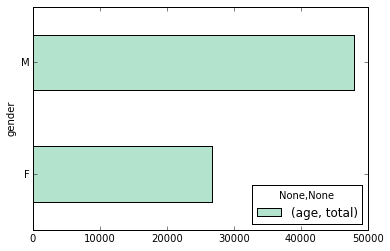

In [17]:
%matplotlib inline
train.groupby('gender').agg({'age':{'total':'count'}}).plot(kind='barh', colormap='Pastel2')

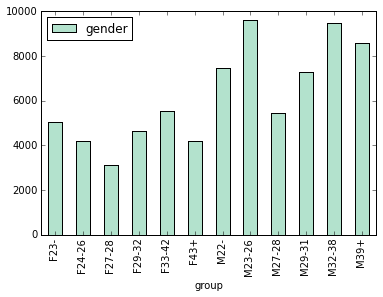

In [18]:
train.groupby('group').agg({'gender':'count'}).plot(kind='bar', colormap='Pastel2')

## Prepare data and transform (Categorize data)

Before joining data between event_application / event / train / test. This help us for separating data before using with model 

Events and app_events

In one event, it indicate one device which mean one user. One event can have many app events.

So we will perform join between event and app event

- remove unnessesary columns in train.
- create new column in train and test to indicate index
- create Y from train
- transform app_id in app_event
- transform app_label in app_labels
- join between event and app event



In [20]:
train['train_index'] = np.arange(train.shape[0])
test['test_index'] = np.arange(test.shape[0])
train = train.drop(['gender','age'], axis=1)
train.head(3)

,group,train_index
device_id,,
-8076087639492063270,M32-38,0
-2897161552818060146,M32-38,1
-8260683887967679142,M32-38,2


In [21]:
y_encoder = LabelEncoder().fit(train.group)
train['group'] = y_encoder.transform(train.group)
yclasses_ = len(y_encoder.classes_)
print 'total number of target classes: ', yclasses_, y_encoder.classes_

total number of target classes:  12 ['F23-' 'F24-26' 'F27-28' 'F29-32' 'F33-42' 'F43+' 'M22-' 'M23-26' 'M27-28'
 'M29-31' 'M32-38' 'M39+']


In [22]:
label_cate = pd.read_csv('Data/label_categories.csv')

In [23]:
app_labels = app_labels.loc[app_labels.app_id.isin(app_events.app_id.unique())]

app_encoder = LabelEncoder().fit(app_events.app_id)
label_encoder = LabelEncoder().fit(app_labels.label_id)
app_events['app'] = app_encoder.transform(app_events.app_id)
app_labels['app'] = app_encoder.transform(app_labels.app_id)
app_labels['label'] = label_encoder.transform(app_labels.label_id)

In [24]:
app_id_to_label = app_labels.join(label_cate, how='left', on='label_id', lsuffix='k')[['app_id','app','label','category']]

In [25]:
joined_app_events = app_events.join(events)
joined_app_events = joined_app_events.groupby(['device_id','app'])['app'].agg(['size'])
joined_app_events = ((joined_app_events.join(train['train_index'], how='left')).join(test['test_index'], how='left')).reset_index()

In [26]:
joined_labels = joined_app_events.merge(app_labels[['app','label']])[['device_id','label','app']]
joined_labels = joined_labels.groupby(['device_id','label'])['app'].agg(['size'])
joined_labels = ((joined_labels.join(train['train_index'], how='left')).join(test['test_index'], how='left')).reset_index()

In [39]:
print 'total device that has event data:' , len(events['device_id'].unique())

has_events_devices = set(events['device_id'].unique())

no_event_train = len(set(train.index.unique()) - has_events_devices)
no_event_test = len(set(test.index.unique()) - has_events_devices)

print '[train]devices that does not have application information:', no_event_train
print '[test]devices that does not have application information:', no_event_test

print '[train] train that has app data percentage:', (len(train) - no_event_train) / float(len(train))
print '[test] train that has app data percentage:', (len(test) - no_event_test) / float(len(test))



total device that has event data: 60865
[train]devices that does not have application information: 51336
[test]devices that does not have application information: 76877
[train] train that has app data percentage: 0.312264719673
[test] train that has app data percentage: 0.314033068323


App event in training data set 
- Only 25650 training devices has app data (~31%)
- Only 37532 test devices has app data (~ 31%)
Really low, so we need to focus on somethings else. Not, app and label...

Both of train and text has roughly percent of no event records. 

**So... original data was split equally.(Stratified)**

** Even we use events to perfectly predict, it still cover only 31% of overall data. So it's nearly impossible to go up more than 30% accurate on just events ** 

## Brand

Total brand : 131 unique brand. every data has brand

In [10]:
brand_encoder = LabelEncoder().fit(phone_data.phone_brand)
phone_data['converted_brand_only'] = brand_encoder.transform(phone_data.phone_brand)

train['brand_only'] = phone_data['converted_brand_only']
test['brand_only'] = phone_data['converted_brand_only']

sparse_train_brand_only = csr_matrix((np.ones(train.shape[0]), (train.train_index, train.brand_only)))
sparse_test_brand_only = csr_matrix((np.ones(test.shape[0]), (test.test_index, test.brand_only)))
print sparse_train_brand_only.shape, sparse_test_brand_only.shape

(74645, 131) (112071, 131)


## Time STAMP CONVERSION

into hour

In [12]:
events['hour'] = pd.to_datetime(events['timestamp']).dt.hour

In [43]:
events.

,device_id,timestamp,longitude,latitude
event_id,,,,
1,29182687948017175,2016-05-01 00:55:25,121.38,31.24
2,-6401643145415154744,2016-05-01 00:54:12,103.65,30.97
3,-4833982096941402721,2016-05-01 00:08:05,106.60,29.70
4,-6815121365017318426,2016-05-01 00:06:40,104.27,23.28
5,-5373797595892518570,2016-05-01 00:07:18,115.88,28.66


In [13]:
stampping = events.groupby(['device_id','hour'])['timestamp'].agg(['size'])
stampping = ((stampping.join(train['train_index'], how='left')).join(test['test_index'], how='left')).reset_index()

In [14]:
d = stampping.dropna(subset=['train_index'])
sparse_event_time_train = csr_matrix((np.ones(d.shape[0]), (d.train_index, d.hour)), shape=(train.shape[0], 24))
d = stampping.dropna(subset=['test_index'])
sparse_event_time_test = csr_matrix((np.ones(d.shape[0]), (d.test_index,d.hour)), shape=(test.shape[0], 24))
print sparse_event_time_train.shape, sparse_event_time_test.shape

(74645, 24) (112071, 24)


## Feature engineer : Brand + Phone Model (One Hot encoding)

Convert phone model from string by label it and transform into one hot encoding.
Same approach as brand

- Concat phone model string with brand string to create unique model approach

Convert brand from string by label it and transform into one hot encoding.

<table>
<tr>
<th>device_id</th>
<th>brand 1 model 1</th>
<th>brand 2 model 1</th>
<th>...</th>
<th>brand n model m</th>
</tr>
<tr>
<td>device_1</td>
<td>1</td>
<td>0</td>
<td>...</td>
<td>0</td>
</tr>
<tr>
<td>device_2</td>
<td>0</td>
<td>1</td>
<td>...</td>
<td>0</td>
</tr>
</table>

the data will be in form of sparse matrix (row) for better performance.

- Join brand and model 
- LabelEncoding phone brand.
- Join them into train/test data by device_id (already declared as index)
- becareful, since csr_matrix does not support negative row index, so we cannot use device_id


In [11]:
model = phone_data.phone_brand.str.cat(phone_data.device_model)

phone_encoder = LabelEncoder().fit(model)
phone_data['converted_brand'] = phone_encoder.transform(model)

train['brand'] = phone_data['converted_brand']
test['brand'] = phone_data['converted_brand']

sparse_train_brand = csr_matrix((np.ones(train.shape[0]), (train.train_index, train.brand)))
sparse_test_brand = csr_matrix((np.ones(test.shape[0]), (test.test_index, test.brand)))
print sparse_train_brand.shape, sparse_test_brand.shape

(74645, 1667) (112071, 1667)


## Feature, App active

Convert joined app_events into sparse matrix.

<table>
<tr>
<th>device_id</th>
<th>app 1</th>
<th>app 2</th>
<th>...</th>
<th>app n</th>
</tr>
<tr>
<td>device_1</td>
<td>1</td>
<td>0</td>
<td>...</td>
<td>0</td>
</tr>
<tr>
<td>device_2</td>
<td>0</td>
<td>1</td>
<td>...</td>
<td>0</td>
</tr>
</table>

total apps in this dataset is 19237

In [16]:
d = joined_app_events.dropna(subset=['train_index'])
sparse_train_appusage = csr_matrix((np.ones(d.shape[0]), (d.train_index, d.app)), shape=(train.shape[0],len(app_encoder.classes_)))
d = joined_app_events.dropna(subset=['test_index'])
sparse_test_appusage = csr_matrix((np.ones(d.shape[0]), (d.test_index,d.app)), shape=(test.shape[0],len(app_encoder.classes_)))
print sparse_train_appusage.shape, sparse_test_appusage.shape

(74645, 19237) (112071, 19237)


## Feature, Label

Label represent application category. One application can be in many label, and one device can have many applications.

Using sparse matrix, we can represent how many diversity of target phone is. One row in sparse mean 
    - how many app category that user interested in
    
** However ** using sparse matrix does not represent which category user interested in the most. or in order.

In [17]:
d = joined_labels.dropna(subset=['train_index'])
sparse_train_label = csr_matrix((np.ones(d.shape[0]), (d.train_index,d.label)), shape=(train.shape[0], len(label_encoder.classes_)))
d = joined_labels.dropna(subset=['test_index'])
sparse_test_label = csr_matrix((np.ones(d.shape[0]), (d.test_index,d.label)),shape=(test.shape[0], len(label_encoder.classes_)))
print sparse_train_label.shape, sparse_test_label.shape

(74645, 492) (112071, 492)


In [55]:
save_sparse('WorkSpace/sprm_brand_train',sparse_train_brand)
save_sparse('WorkSpace/sprm_brand_test',sparse_test_brand)
save_sparse('WorkSpace/sprm_label_train', sparse_train_label)
save_sparse('WorkSpace/sprm_label_test', sparse_test_label)
save_sparse('WorkSpace/sparse_train_appusage', sparse_train_appusage)
save_sparse('WorkSpace/sparse_test_appusage', sparse_test_appusage)
#add 2016-08-30
save_sparse('WorkSpace/sparse_event_time_train', sparse_event_time_train)
save_sparse('WorkSpace/sparse_event_time_test', sparse_event_time_test)
save_sparse('WorkSpace/sparse_train_brand_only', sparse_train_brand_only)
save_sparse('WorkSpace/sparse_test_brand_only', sparse_test_brand_only)

## Feature combine and save

In [56]:
Xtrain = hstack((sparse_train_brand_only, sparse_train_brand,  sparse_train_appusage, sparse_train_label,sparse_event_time_train), format='csr')
Xtest =  hstack((sparse_test_brand_only, sparse_test_brand, sparse_test_appusage, sparse_test_label, sparse_event_time_test), format='csr')
print Xtrain.shape, Xtest.shape

(74645, 21551) (112071, 21551)


In [57]:
train[['train_index','group']].to_csv('WorkSpace/Ytrain.csv', index=False)

In [94]:
save_sparse('WorkSpace/sprm_train_additional', Xtrain)
save_sparse('WorkSpace/sprm_test_v2', Xtest)


## Transformation

- PCA on each unit
- Kernel PCA
- Log ?
- Many things

In [18]:
""" Keep only sparse """
del train 
del test 
del phone_data 
del events 
del app_events
del app_labels

In [20]:
from sklearn.decomposition import PCA
from scipy.sparse import vstack
# expect 95% of coverage
# label



In [34]:
def apply_pca(sparse, variance=0.95):
    pca = PCA(n_components= variance)
    pca.fit(sparse.toarray())
    print 'number of reduced components: ', pca.n_components_
    return pca.transform(sparse.toarray())

def train_test_pca(train_sparse, test_sparse, variance=0.95):
    cutoff_idx = train_sparse.shape
    whole_sparse = vstack((train_sparse, test_sparse))
    print 'before pca, components: ' , cutoff_idx[1]
    transformed = apply_pca(whole_sparse, variance)
    train_transformed = transformed[:cutoff_idx[0], :]
    test_transformed = transformed[cutoff_idx[0]:,:]
    return train_transformed, test_transformed
    

In [35]:
train_label_pca, test_label_pca = train_test_pca(sparse_train_label,sparse_test_label)

before pca, components:  492
number of reduced components:  146


In [ ]:
train_app_pca, test_app_pca = train_test_pca(sparse_train_appusage,sparse_test_appusage)